In [1]:
import numpy as np
import scipy as scp
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import PIL
import glob
import cv2
import json
from sklearn.externals import joblib


%matplotlib inline

# Import

In [2]:
def img2array(path):
    img = PIL.Image.open(path).convert('L')
    return np.array(img)


#  Training data
train_pos_im_array = np.array([img2array(path) for path in 
                     sorted(glob.glob('lib/INRIAPerson/train_64x128_H96/pos/*'))])
#  need to sample 10 windows from each of these
train_raw_neg_im_array = np.array([img2array(path) for path in 
                       sorted(glob.glob('lib/INRIAPerson/train_64x128_H96/neg/*'))])

#  Testing data
test_pos_full_im_array = np.array([img2array(path) for path in 
                       sorted(glob.glob('lib/INRIAPerson/Test/pos/*'))])
test_neg_full_im_array = np.array([img2array(path) for path in 
                       sorted(glob.glob('lib/INRIAPerson/Test/neg/*'))])

#  Testing Annotations
#  need pos test names in order to grab pos annotations at test time
test_pos_full_im_names = \
            [path.split("/")[-1] for path in sorted(glob.glob('lib/INRIAPerson/Test/pos/*'))]

#  I'll be using IOU (need 50% overlap) to asses if the model (windowing + nms) gets close to
#  original recognitions
test_annotations = json.load(open("lib/INRIAPerson/Test/inria_annotations.json"))
test_annotations = test_annotations['test']

In [3]:
train_pos_im_array.shape

(2416, 160, 96)

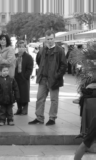

In [4]:
PIL.Image.fromarray(train_pos_im_array[0])

In [5]:
train_pos_im_array[0]

array([[199, 189, 171, ..., 116, 151, 151],
       [199, 189, 171, ..., 116, 151, 151],
       [199, 189, 171, ..., 116, 151, 151],
       ..., 
       [182, 185, 181, ..., 173, 173, 173],
       [180, 177, 178, ..., 169, 172, 172],
       [180, 177, 178, ..., 169, 172, 172]], dtype=uint8)

In [6]:
train_pos_im_array[0].shape

(160, 96)

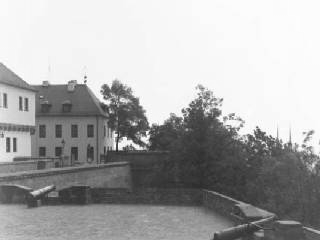

In [7]:
PIL.Image.fromarray(train_raw_neg_im_array[0])

In [8]:
train_raw_neg_im_array[0]

array([[250, 250, 250, ..., 252, 252, 252],
       [250, 250, 250, ..., 252, 252, 252],
       [250, 250, 250, ..., 252, 252, 252],
       ..., 
       [190, 188, 190, ...,  99,  95,  91],
       [210, 205, 205, ...,  94,  98, 101],
       [200, 195, 197, ...,  96,  94,  92]], dtype=uint8)

In [9]:
train_raw_neg_im_array[0].shape

(240, 320)

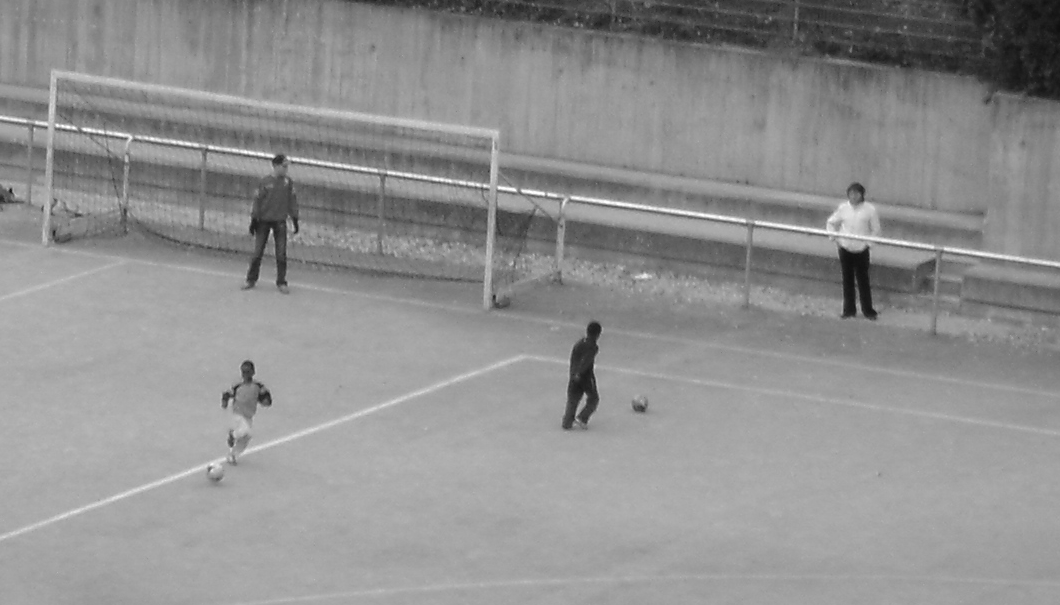

In [10]:
PIL.Image.fromarray(test_pos_full_im_array[0])

In [11]:
test_pos_full_im_array[0]

array([[136, 135, 137, ...,  29,  27,  27],
       [136, 135, 137, ...,  29,  26,  25],
       [135, 135, 137, ...,  27,  23,  23],
       ..., 
       [162, 162, 162, ..., 154, 157, 160],
       [162, 163, 164, ..., 157, 155, 155],
       [160, 162, 165, ..., 156, 155, 154]], dtype=uint8)

In [12]:
test_pos_full_im_array[0].shape

(605, 1060)

In [13]:
test_annotations[test_pos_full_im_names[0]]

[{u'bottom': 294,
  u'left': 250,
  u'right': 299,
  u'top': 151,
  u'type': u'UprightPerson',
  u'xcenter': 281,
  u'ycenter': 169},
 {u'bottom': 433,
  u'left': 568,
  u'right': 607,
  u'top': 320,
  u'type': u'UprightPerson',
  u'xcenter': 594,
  u'ycenter': 336},
 {u'bottom': 466,
  u'left': 215,
  u'right': 274,
  u'top': 354,
  u'type': u'UprightPerson',
  u'xcenter': 247,
  u'ycenter': 373},
 {u'bottom': 321,
  u'left': 829,
  u'right': 881,
  u'top': 180,
  u'type': u'UprightPerson',
  u'xcenter': 856,
  u'ycenter': 200}]

In [43]:
#  clean annotations for use in accuracy verification
test_all_im_windows = []

for i in range(len(test_pos_full_im_names)):
    
    im_windows = []
    for window in test_annotations[test_pos_full_im_names[i]]:
        im_windows.append([window['left'], window['top'], window['right'], window['bottom']])
        
    test_all_im_windows.append(im_windows)

In [42]:
test_all_im_windows[30]

[[304, 222, 461, 696]]

#  Sliding Window

In [14]:
#  Implement sliding window breakup piece

#  takes an image and returns a list of valid window locations at various scales and locations
def sliding_window(im, random_sample=False):
    im_x = im.shape[1]
    im_y = im.shape[0]

    #  this is the starting window size, it changes at each scale
    window_size_x = 100
    window_size_y = 200
    scale_factor = 1.5
    if random_sample:
        window_size_x = 96
        window_size_y = 160

        
    sliding_window_ims = []
    #  TODO: I might need to seperate by scale, maybe
    sliding_window_im_locations = []  #  top, bottom, left, right



    #  while the window sizes are smaller then the image
    while(window_size_x < im_x and window_size_y < im_y):


        #  set the stride of the sliding window to scale with the window size, that way everything overlaps by 1/4
        stride_x = int(window_size_x * 0.25)
        stride_y = int(window_size_y * 0.25)



        #  find the upper left corner for each window, move by scaled strides
        for x in np.arange(0, im_x, stride_x):
            if x + window_size_x > im_x:  break

            for y in np.arange(0, im_y, stride_y):
                if y + window_size_y > im_y:  break

                #  save all valid window coordinates
                sliding_window_im_locations.append([x, y,  x + window_size_x, y + window_size_y])




        window_size_x = window_size_x * scale_factor
        window_size_y = window_size_y * scale_factor

    if random_sample:
        return np.asarray(sliding_window_im_locations)[np.random.choice(len(sliding_window_im_locations), 4)]
    
    return np.asarray(sliding_window_im_locations)

In [15]:
print(sliding_window(test_pos_full_im_array[0]).shape)
sliding_window(test_pos_full_im_array[0])[214]

(506, 4)


array([ 575.,  350.,  675.,  550.])

# Extract Neg Train Windows

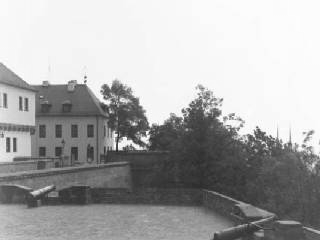

In [16]:
#  test extracting 10 images from this one
PIL.Image.fromarray(train_raw_neg_im_array[0])

In [17]:
train_neg_im_array = []

#  go through every negative image
for im in train_raw_neg_im_array:
    
    #  sample 10 random subwindows and save those images in a train_neg_im_array for training
    im_raw = PIL.Image.fromarray(im)
    sample_windows = sliding_window(train_raw_neg_im_array[44], random_sample=True)
    for window in sample_windows:
        train_neg_im_array.append(im_raw.crop(window))

train_neg_im_array = np.asarray([np.array(im) for im in train_neg_im_array])
train_neg_im_array.shape

(4872, 160, 96)

In [18]:
train_neg_im_array[0]

array([[246, 246, 246, ..., 248, 248, 248],
       [246, 246, 246, ..., 248, 248, 248],
       [246, 246, 246, ..., 248, 248, 248],
       ..., 
       [ 60,  60,  62, ...,  70,  64,  60],
       [ 67,  66,  65, ...,  74,  67,  60],
       [ 75,  72,  68, ...,  83,  74,  66]], dtype=uint8)

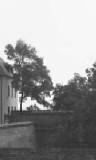

In [19]:
PIL.Image.fromarray(train_neg_im_array[0])

#  Combine Training Data

In [20]:
train_labels = np.asarray(([0] * len(train_neg_im_array)) + ([1] * len(train_pos_im_array)))
print(train_labels)
print(train_labels.shape)

train_im_array = np.vstack((train_neg_im_array, train_pos_im_array))
train_im_array.shape

[0 0 0 ..., 1 1 1]
(7288,)


(7288, 160, 96)

In [21]:
#  shuffle the data
shuffled_tmp = np.asarray(list(zip(train_im_array, train_labels)))
np.random.shuffle(shuffled_tmp)

train_im_array = shuffled_tmp[:,0]
train_im_array = np.asarray(list(train_im_array)).squeeze()
train_labels = shuffled_tmp[:,1]
print(train_im_array.shape)
train_labels

(7288, 160, 96)


array([0, 0, 0, ..., 0, 0, 0], dtype=object)

# Model Definition

In [22]:
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV


import warnings
warnings.filterwarnings('ignore')

In [83]:
#  local variables to speed up repeat runs
kmeans_features_global = None
rf_clf_global = None

In [114]:
class visual_classifier:
    def __init__(self):
        self.num_features = 30
    
    def fit_custom(self, pipeline_path, x_train, y_train, x_test, y_test, train_new=False):
        

        
        
        #  these are arrays of KeyPoints
        self.train_kps = None
        self.test_kps = None
        
        print("Finding Interest Points")    
        print("Generating Description")
        
        
        
#         import pdb
#         pdb.set_trace()


        self.train_kps, self.train_descs = self.sift_interest_point_descriptions(x_train)
        self.test_kps, self.test_descs = self.sift_interest_point_descriptions(x_test)
            
 
        
        print("Pooling")
        

                
        
        self.train_features = None
        self.test_features = None
        if pipeline_path[2].strip().lower() == "vector":
            self.train_features = self.vector_quantization(self.train_descs, train_new)
            self.test_features = self.vector_quantization(self.test_descs, False)
        else:
            self.train_features = self.spatial_pyramid_pooling(self.train_descs, x_train, train_new)
            self.test_features = self.spatial_pyramid_pooling(self.test_descs, False)
            
            
                
        
        print("Classifying")    
        

        #  consolidate features into 1 2d numpy array
        level_train_features = []
        for x in self.train_features:
            if len(x) == 1:
                level_train_features.append(x[0].tolist())
            else:
                level_train_features.append(x)
        self.train_features = np.asarray(level_train_features)

        
        level_test_features = []
        for x in self.test_features:
            if len(x) == 1:
                level_test_features.append(x[0].tolist())
            else:
                level_test_features.append(x)
        self.test_features = np.asarray(level_test_features)

        
            
        return self.classification_accuracy(pipeline_path[3], self.train_features, y_train, 
                                            self.test_features, y_test, fit_new=train_new)
            
       
    
    def predict_prob(self, pipeline_path, x_train, y_train=None, x_train_masks=None, train_new=False):
    
        
        #  these are arrays of KeyPoints
        self.train_kps = None
        
#         print("Finding Interest Points")    
#         print("Generating Description")


        self.train_kps, self.train_descs = self.sift_interest_point_descriptions(x_train, x_train_masks)
            
 
#         print("Pooling")
    
        
        self.train_features = None
        if pipeline_path[2].strip().lower() == "vector":
            self.train_features = self.vector_quantization(self.train_descs, train_new)
        else:
            self.train_features = self.spatial_pyramid_pooling(self.train_descs, x_train, train_new)
            
        
        
        #  consolidate features into 1 2d numpy array
        level_train_features = []
        for x in self.train_features:
            if len(x) == 1:
                level_train_features.append(x[0].tolist())
            else:
                level_train_features.append(x)
        self.train_features = np.asarray(level_train_features)
            
            
                
#         print("Classifying")    
        
        if y_train is None:
            return self.classification_prob(pipeline_path[3], self.train_features, fit_new=train_new)
        
            
        return self.classification_prob(pipeline_path[3], self.train_features, y_train.as_matrix(), fit_new=train_new)
    
        
        
    """Model Visualization Methods"""
    def display_visual_feature_sampeles(self, x_train):
        

    
        #  use one image, find a few keypoints from the same class
        for im_kp_descs, x_im in zip(self.train_descs, x_train):
            kps = im_kp_descs[0]  #  use this for keypoint
            descs = im_kp_descs[1]
            
            classes = []
            for i in range(len(descs)):
                classes.append(self.kmeans_features.predict(descs[0]))
        
        
            #  I need to make sure this is an ordered list of kps in the image
            #  if it is this I'll just filter by one group at a time and take the first 10 images
            #  then I'll print the first 10 instances of the class using the keypoint location
            #  and the passed image
            return sorted(list(zip(kps, classes)), lambda x: x[1]), x_im
        
            break
        
        
    def display_avg_class_histogram():
        #  summary histograms have been generated, one for each image
        sorted_im_hists = sorted(list(zip(self.train_features, y_train.as_matrix())), lambda x: x[0])
        sorted_im_hists_df = pd.DataFrame(sorted_im_hists, columns=["feature","class"])
        avg_im_hists_df = sorted_im_hists_df.groupby("class").avg()
        avg_features = avg_im_hists_df["feature"].as_matrix()
        
        #  trasform so that I can plot them
        plt.pcolor(avg_features)  #  maybe
        plt.show()
        
        
        
        
        
        
    
    """Interest point detectors"""

    def sift_interest_point_descriptions(self, passed_im, masks=None):
        self.sift = cv2.SIFT()


        # find the keypoints with SIFT
        #  find all interest points for all images

#         import pdb
#         pdb.set_trace()


        tmp_output = None
        kps = None
        des = None

        if masks is not None:
            #  if passing a list of masks then passed_im is a single image and we need to iterate through
            #  masks to find keypoints for all specified subimages
            tmp_output = [self.sift.detectAndCompute(passed_im[masks[i][1]:masks[i][3], masks[i][0]:masks[i][2]],None) \
                          for i in range(len(masks))]
#             kps = tmp_output[0][0]
#             des = tmp_output[0][1]
            kps = np.asarray(list(tmp_output))[:,0]
            des = np.asarray(list(tmp_output))[:,1]


        else:
            tmp_output = [self.sift.detectAndCompute(img,None) for img in passed_im]
            kps = np.asarray(list(tmp_output))[:,0]
            des = np.asarray(list(tmp_output))[:,1]

    #     kps = np.asarray(list(tmp_output[0]))[:,0]
    #     des = np.asarray(list(tmp_output[0]))[:,1]


        return kps, des
    

    

    
    
    
    """Pooling"""
    def define_features(self, im_kp_descs):
        #  first you need to create a kmeans model which will find the k features present in the computed
        #  feature descriptions
        #  used the entire dataset, just cluster all descriptions together

#         #  for lbp
#         all_feature_descriptions = np.array(results[0][1])
#         for i in range(1, len(results) - 1):
#             if len(results[i][1]) > 0:
#                 all_feature_descriptions = np.vstack([all_features, np.vstack(results[i][1])])
        
    
        #  used with SIFT combined kp/desc
        tmp_descs = im_kp_descs[im_kp_descs != np.array(None)]
        all_feature_descriptions = np.vstack(tmp_descs)
    
    
        #  standard pipeline
#         all_feature_descriptions = np.vstack(im_kp_descs[:,1])
        self.kmeans_features = KMeans(n_clusters=self.num_features, n_jobs=-1).fit(all_feature_descriptions)
        
    def vector_quantization(self, im_kp_descs, train_new=False):
        #  for each image, go through the feature descriptions one by one, use the k-means model to
        #  place each feature in a cluster, then ++ the feature count for that feature
        #  this list is the final histogram which we'll feed into a ML model
        #  essentially we reducing the problem to one where we count to number of occurances of each type of feature
        #  and use this final histogram as the only input to a ML model

        global kmeans_features_global
        
        
        if train_new:
            
            self.define_features(im_kp_descs)

            #  save to file with joblib
            joblib.dump(self.kmeans_features, "internal_vector_quant_model")
            kmeans_features_global = self.kmeans_features

            
        else:
            #  load from file with joblib
            if kmeans_features_global is None:
                self.kmeans_features = joblib.load("internal_vector_quant_model")
                kmeans_features_global = self.kmeans_features
            else:
                self.kmeans_features = kmeans_features_global
        
        
        
        
        training_hists = []

        for im in im_kp_descs:
            #  TODO: fix, I need to handle None values here
            
            #  kps = im[0]  #  use this for coords later
#             descs = im[1]
            descs = im

            im_hist = np.zeros(self.num_features)
            if descs is None:
                training_hists.append(im_hist)
                continue
                
            for desc in descs:
                new_feature_num = self.kmeans_features.predict(desc)
                im_hist[new_feature_num] += 1

            training_hists.append(normalize(im_hist))
        return np.asarray(training_hists)
    
    
    def get_hist_grid_bin(self, x, y, height, width):
        x_bin = int((float(x) / float(width)) * 4.0)
        y_bin = int((float(y) / float(height)) * 4.0)
        return (4 * y_bin) + x_bin

    def spatial_pyramid_pooling(self, all_im_kp_descs, all_x_im_train, train_new=False):
        #  for each image, go through the feature descriptions and their coords one by one, use the k-means model to
        #  place each feature in a cluster at it's location, then ++ the feature count for that feature at the coord
        #  once concatenated all together this list is the final histogram which we'll feed into a ML model
        #  essentially we reducing the problem to one where we count to number of occurances of each type of feature
        #  and use this final histogram as the only input to a ML model
        
        
        
        if train_new:
            
            self.define_features(im_kp_descs)

            #  save to file with joblib
            joblib.dump(self.kmeans_features, "internal_vector_quant_model")

        else:
            #  load from file with joblib
            self.kmeans_features = joblib.load("internal_vector_quant_model")
        
        
        training_hists = []

        for im_kp_descs, x_im in zip(all_im_kp_descs, all_x_im_train):
            kps = im_kp_descs[0]  #  use this for keypoint
            descs = im_kp_descs[1]
            height = x_im.shape[1]
            width = x_im.shape[0]

            #  grid layout
            #   0, 1, 2, 3
            #   4, 5, 6, 7
            #   8, 9,10,11
            #  12,13,14,15

            im_hist_level_2 = np.zeros((16, self.num_features))
            im_hist_level_1 = np.zeros((4, self.num_features))
            im_hist_level_0 = np.zeros(self.num_features)


            for kp, desc in zip(kps[1], descs):
                new_feature_num = self.kmeans_features.predict(desc)
                #  ++ the found feature count of the correct coordinate bin in the level 2 grid
                im_hist_level_2[self.get_hist_grid_bin(kp.pt[1], kp.pt[0], height, width)]\
                                    [new_feature_num] += 1

            im_hist_level_1[0] = im_hist_level_2[0] + im_hist_level_2[1] + im_hist_level_2[4] + im_hist_level_2[5]
            im_hist_level_1[1] = im_hist_level_2[2] + im_hist_level_2[3] + im_hist_level_2[6] + im_hist_level_2[7]
            im_hist_level_1[2] = im_hist_level_2[8] + im_hist_level_2[9] + im_hist_level_2[12] + im_hist_level_2[13]
            im_hist_level_1[3] = im_hist_level_2[10] + im_hist_level_2[11] + im_hist_level_2[14] + im_hist_level_2[15]
            im_hist_level_0 = im_hist_level_1.sum(axis=0)   


            #  add flatened weighted layers together then normalize
            im_hist_combined = np.concatenate((im_hist_level_0.flatten() * 0.25, im_hist_level_1.flatten() * 0.25))
            im_hist_combined = np.concatenate((im_hist_combined, im_hist_level_2.flatten() * 0.5))
            training_hists.append(normalize(im_hist_combined))

        return np.asarray(training_hists)
    
    
    
    
    """Classification"""
    def generate_prec_rec_curve(self, y_true, y_pred_prob):
        precisions = []
        recalls = []

        for threshold in np.arange(0,1, 0.001):
            y_thresholded_pred = (y_pred_prob > threshold) * 1.0
            tp = tn = fp = fn = 0

            for i in range(len(y_true)):
                if y_true[i] == 0:
                    if y_thresholded_pred[i] == 0:
                        tn += 1
                    else:
                        fp += 1
                else:
                    if y_thresholded_pred[i] == 1:
                        tp += 1
                    else:
                        fn += 1

            if tp + fp == 0:
                break
    #             precisions.append(0.0)
            else:
                precisions.append(tp / float(tp + fp))
            if tp + fn == 0:
                break
    #             recalls.append(0.0)
            else:
                recalls.append(tp / float(tp + fn))

        return precisions, recalls

    def display_all_class_pr_curves(self, test_y_ohe, score_y):
        for i in range(test_y_ohe.shape[1]):
            pr_curve = self.generate_prec_rec_curve(test_y_ohe[:, i], score_y[:, i])
            plt.plot(pr_curve[1], pr_curve[0])
        plt.xlabel("recall")
        plt.ylabel("precision")
        plt.ylim(0, 1.1)
    
    def one_hot_encoding(self, passed_y, n_classes):
        final_labels = []

        for y in passed_y:
            encoded_array = np.zeros(n_classes)
            encoded_array[y - 1] = 1
            final_labels.append(encoded_array)

        return np.asarray(final_labels)
    
    
    def display_confusion_matrix(self, test_y, pred_y):
        cm = np.zeros((10,10))
        for i in range(len(test_y)):
            cm[test_y[i] - 1][pred_y[i] - 1] += 1

        #  normalize
        for i in range(len(cm)):
            if cm[i].sum() > 0:
                cm[i] = cm[i] / cm[i].sum()
    
        self.cm = cm
        print ("Confusion Matrix")
        print (cm)
    
    
    
    def classification_accuracy(self, classifier_str, train_x, train_y, test_x, test_y, fit_new=False):
        global rf_clf_global
        
        #  reduce to proper dimensions for classifier
        train_x = train_x.squeeze()
#         train_y = train_y.squeeze()
        test_x = test_x.squeeze()
#         test_y = test_y.squeeze()
#         test_y_ohe = self.one_hot_encoding(test_y, 10)
        test_y_ohe = self.one_hot_encoding(test_y, 2)


        
        
        if classifier_str.strip().lower() == "random forest":
            
            #  if they want a new model fit it and save to file, otherwise load existing model
            if fit_new:
        
                self.rf_clf_pre = RandomForestClassifier(n_estimators=10000)
                #  calibrate probabilities
                self.rf_clf = CalibratedClassifierCV(base_estimator=self.rf_clf_pre, 
                                       method='sigmoid', cv=10)
                self.rf_clf.fit(train_x, train_y)
            
                
                #  save to file with joblib
                joblib.dump(self.rf_clf, "internal_detection_model")
                rf_clf_global = self.rf_clf
                
            else:
                #  load from file with joblib
                if rf_clf_global is None:
                    self.rf_clf = joblib.load("internal_detection_model")
                    rf_clf_global = self.rf_clf
                else:
                    self.rf_clf = rf_clf_global 
                
            
            score_y = self.rf_clf.predict_proba(test_x)
            self.display_all_class_pr_curves(test_y_ohe, score_y)
                        
            pred_y = self.rf_clf.predict(test_x)
            self.display_confusion_matrix(test_y, pred_y)
            
            return self.rf_clf.score(test_x, test_y)
        

        
        
        
    def classification_prob(self, classifier_str, train_x, train_y=None, fit_new=False):
        global rf_clf_global
        
        #  reduce to proper dimensions for classifier
        train_x = train_x.squeeze()
        if train_y is not None:
            train_y = train_y.squeeze()


        
        
        if classifier_str.strip().lower() == "random forest":
             #  if they want a new model fit it and save to file, otherwise load existing model
            if fit_new:
                
                self.rf_clf_pre = RandomForestClassifier(n_estimators=10000)
                #  calibrate probabilities
                self.rf_clf = CalibratedClassifierCV(base_estimator=self.rf_clf_pre, 
                                       method='sigmoid', cv=10)
                self.rf_clf.fit(train_x, train_y)
                
                
                #  save to file with joblib
                joblib.dump(self.rf_clf, "internal_detection_model")
                rf_clf_global = self.rf_clf

                
            else:
                #  load from file with joblib
                if rf_clf_global is None:
                    self.rf_clf = joblib.load("internal_detection_model")
                    rf_clf_global = self.rf_clf
                else:
                    self.rf_clf = rf_clf_global 
                
            
            
            score_y = self.rf_clf.predict_proba(train_x)
            
            return score_y
            
            
            


#  Train Internal Classification Model

Finding Interest Points
Generating Description
Pooling
Classifying
Confusion Matrix
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


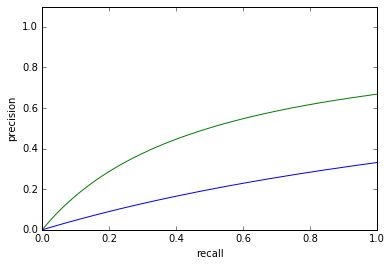

In [26]:
#  Sift key points, Sift descriptions, Spatial Pyramid Vectorization, Random Forest Classifier
clf = visual_classifier()
train_features_tmp = clf.fit_custom(["sift","sift","vector","random forest"], train_im_array, 
                train_labels.astype("float64"), train_im_array, train_labels.astype("float64"), train_new=False)

Finding Interest Points
Generating Description
Pooling
Classifying
Confusion Matrix
[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


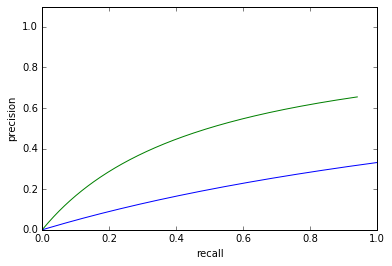

In [135]:
# #  Sift key points, Sift descriptions, Spatial Pyramid Vectorization, Random Forest Classifier
# clf = visual_classifier()
# train_features_tmp = clf.fit_custom(["sift","sift","vector","random forest"], train_im_array, 
#                 train_labels.astype("float64"), train_im_array, train_labels.astype("float64"))

# Visualize Results

In [48]:
#  need a function to visualize window probabilities and windows

import matplotlib.patches as patches

def visualize_windows(im, windows, windows_unreduced, window_probs_unreduced):
    fig, axes = plt.subplots(2,1, figsize=(20,15))
    _draw_windows(im, windows, axes[0])
    _window_heatmap(im, windows_unreduced, window_probs_unreduced, axes[1])



def _draw_windows(im, windows, ax):
    ax.imshow(im,cmap='gray')
    
    for window in windows:
        # Create a Rectangle patch
        rect = patches.Rectangle((window[0], window[1]),window[2] - window[0],window[3] - window[1],
                                 linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show

def _window_heatmap(im, windows, window_probs, ax):
    ax.imshow(im,cmap='gray')
    
    
    heatmap_totals = np.zeros((im.shape))
    heatmap_counts = np.zeros((im.shape))
    
    
    #  TODO:  probably need to populate an (im sized) array instead of drawing a bunch of 
    #  rectangles, then I'll simply normalize the matrix to get probs then draw each 
    #  pixel with the final intensity
    
    
    for i, window in enumerate(windows):
        # Create a Rectangle patch
        
        heatmap_totals[window[1]:window[3], window[0]:window[2]] += float(window_probs[i])
        heatmap_counts[window[1]:window[3], window[0]:window[2]] += 1.0
        
#         rect = patches.Rectangle((window[0], window[1]),window[2] - window[0],window[3] - window[1],
#                                  linewidth=1,edgecolor='r',facecolor='r', 
#                                  alpha=0.1 * window_probs[i])
#         # Add the patch to the Axes
#         ax.add_patch(rect)



    heatmap_totals = heatmap_totals.astype('float32')
#     heatmap_counts = heatmap_counts.astype('float32')
#     heatmap = heatmap_totals / heatmap_counts
    heatmap = heatmap_totals
    heatmap *= (255.0 / float(heatmap.max()))    
    plt.imshow(PIL.Image.fromarray(heatmap.astype('uint8')), alpha=0.2)
    
    
    

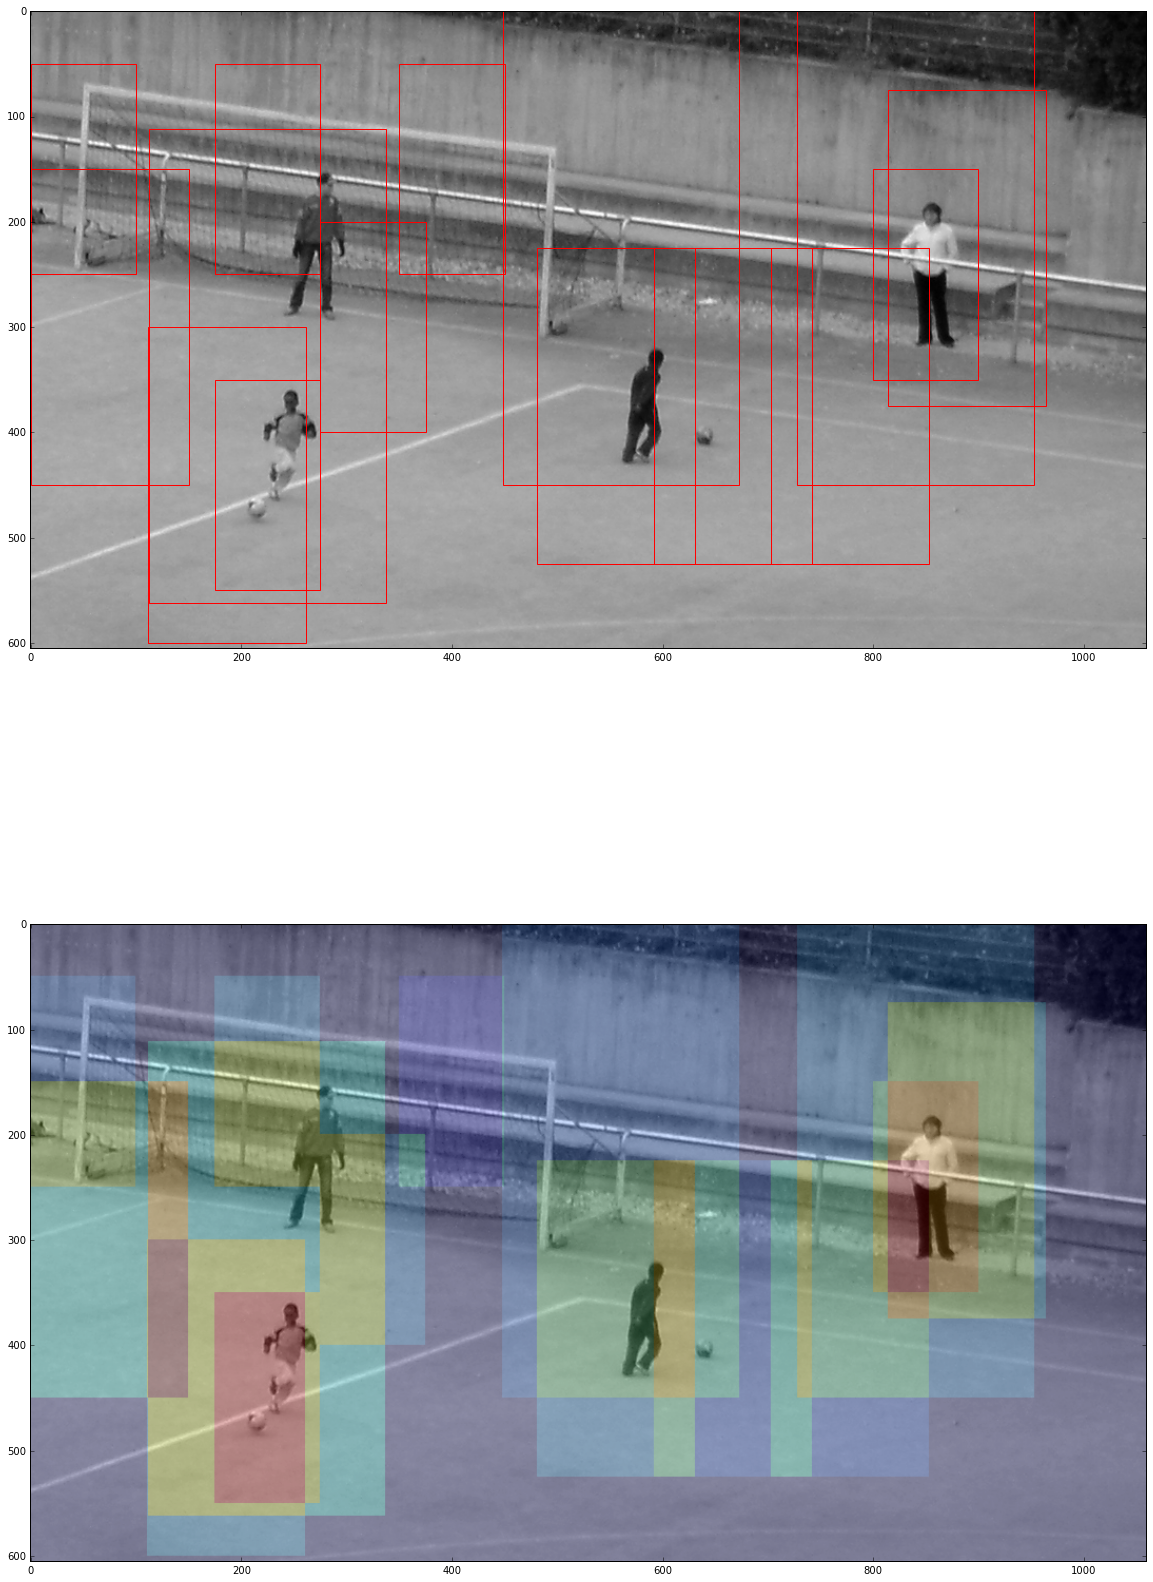

In [86]:
# you need to allow all windows through to display proper heatmap
visualize_windows(test_im, test_im_windows_reduced, window_probs_reduced[:,1])


#  Use Sliding Window and NMS for Object Detection

In [120]:
def iou(window1, window2):
    area_window1 = (window1[2] - window1[0]) * (window1[3] - window1[1]) 
    area_window2 = (window2[2] - window2[0]) * (window2[3] - window2[1])
    
    x1_inter = np.max((window1[0], window2[0]))
    x2_inter = np.min((window1[2], window2[2]))
    y1_inter = np.max((window1[1], window2[1]))
    y2_inter = np.min((window1[3], window2[3]))
    area_inter = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    
    if float(area_window1 + area_window2 - area_inter) == 0:
        return 0.0, float(area_inter) / float(area_window2)

    return float(area_inter) / float(area_window1 + area_window2 - area_inter), float(area_inter) / float(area_window2)
    


In [121]:
#  adds the appropriate counts to the confusion matrix
def analyze_detections(confusion_mat, predicted_windows, true_windows):
    iou_match_threshold = 0.5
    test_inter_ratio_threshold = 0.7
    
    not_detected = np.ones(len(true_windows))
    
    
#     import pdb
#     pdb.set_trace()
    
    #  go through every true window, find the detected one closest, claim it and update the 
    for predicted_window in predicted_windows:
        
        
        closest_index = -1
        closest_iou = -1.0
        
        #  find the true window closest to the predicted
        for i, true_window in enumerate(true_windows):            
            if not_detected[i] == 1.0:
                iou_value = iou(predicted_window, true_window)

                if iou_value[0] > closest_iou or iou_value[1] > test_inter_ratio_threshold:
                    closest_iou = iou_value
                    closest_index = i
        
        
        #  if a window was found and it's a close enough enough match then tp ++ else fp ++
        if closest_index >= 0:
            if closest_iou[0] >= iou_match_threshold or closest_iou[1] > test_inter_ratio_threshold:
                #  true positive
                confusion_mat[1, 1] += 1
                not_detected[closest_index] = 0.0
                
            else:
                #  false positive
                confusion_mat[0, 1] += 1
            
        else:
            #  false positive
            confusion_mat[0, 1] += 1
    
    
    #  add the rest of the undetected true windows to false negatives
    confusion_mat[1, 0] += not_detected.sum()
    
    
    
    return confusion_mat

In [131]:
def stuff():
    num_test_ims_to_use = 15
    window_iou_threshold = 0.3

    precisions = []
    recalls = []
    confusion_mats = []
    
    
    for class_prob_threshold in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1.0]:
        #  the fill the confusion matrix for that prob theshold, get precision and recall
        #  need to run each confusion matrix through pos and neg test images

        clf = visual_classifier()
        confusion_mat = np.zeros((2,2))



        """Test Positive Windows"""
        test_im = None
        for n, test_im in enumerate(test_pos_full_im_array[0:num_test_ims_to_use]):
            print(n, len(test_pos_full_im_array))
            
            #  get sliding windows
            test_im_windows_original = sliding_window(test_im)

            if len(test_im_windows_original) > 0:
                window_probs_original = clf.predict_prob(["sift","sift","vector","random forest"], test_im,  
                                                         x_train_masks=test_im_windows_original, train_new=False)


                #  filter out low prob positive windows
                pos_indexes = []
                for i, x in enumerate(window_probs_original):
                    if x[1] > class_prob_threshold:
                        pos_indexes.append(i)

                test_im_windows = test_im_windows_original[pos_indexes]
                window_probs = window_probs_original[pos_indexes]



                #  Non-Maximal Supression
                #  only accept the max prob window of windows that overlap it my 50%


                remaining_windows = np.ones(len(test_im_windows))

                #  try every combination of windows
                for i in range(len(test_im_windows)):
                    for j in range(i + 1, len(test_im_windows)):

                        #  if two windows share half of their area then eliminate the smaller one
                        if iou(test_im_windows[i], test_im_windows[j])[0] >= window_iou_threshold:
                            if window_probs[i][1] > window_probs[j][1]:
                                remaining_windows[j] = 0.0
                            else:
                                remaining_windows[i] = 0.0


                test_im_windows_reduced = test_im_windows[remaining_windows.astype(bool)]
                window_probs_reduced = window_probs[remaining_windows.astype(bool)]



                #  analyze predicted windows
                confusion_mat = analyze_detections(confusion_mat, test_im_windows_reduced, test_all_im_windows[0])
            else:
                #  analyze predicted windows
                confusion_mat = analyze_detections(confusion_mat, [], test_all_im_windows[0])



        """Test Negative Windows"""
        for n, test_im in enumerate(test_neg_full_im_array[0:num_test_ims_to_use]):
            print(n, len(test_neg_full_im_array))
            test_im_windows_original = sliding_window(test_im)


            if len(test_im_windows_original) > 0:

                window_probs_original = clf.predict_prob(["sift","sift","vector","random forest"], test_im,  
                                                         x_train_masks=test_im_windows_original, train_new=False)


                #  filter out low prob positive windows
                pos_indexes = []
                for i, x in enumerate(window_probs_original):
                    if x[1] > class_prob_threshold:
                        pos_indexes.append(i)

                test_im_windows = test_im_windows_original[pos_indexes]
                window_probs = window_probs_original[pos_indexes]



                #  Non-Maximal Supression
                #  only accept the max prob window of windows that overlap it my 50%


                remaining_windows = np.ones(len(test_im_windows))

                #  try every combination of windows
                for i in range(len(test_im_windows)):
                    for j in range(i + 1, len(test_im_windows)):

                        #  if two windows share half of their area then eliminate the smaller one
                        if iou(test_im_windows[i], test_im_windows[j])[0] >= window_iou_threshold:
                            if window_probs[i][1] > window_probs[j][1]:
                                remaining_windows[j] = 0.0
                            else:
                                remaining_windows[i] = 0.0


                test_im_windows_reduced = test_im_windows[remaining_windows.astype(bool)]
                window_probs_reduced = window_probs[remaining_windows.astype(bool)]



                #  all windows detected are false positives
                confusion_mat[0, 1] += len(test_im_windows_reduced)




        #  this is the final confusion mat for all test data at this probability threshold
        confusion_mats.append(confusion_mat)
    
    return confusion_mats

confusion_mats_final = stuff()
confusion_mats_final

(0, 288)
(1, 288)
(2, 288)
(3, 288)
(4, 288)
(5, 288)
(6, 288)
(7, 288)
(8, 288)
(9, 288)
(10, 288)
(11, 288)
(12, 288)
(13, 288)
(14, 288)
(0, 453)
(1, 453)
(2, 453)
(3, 453)
(4, 453)
(5, 453)
(6, 453)
(7, 453)
(8, 453)
(9, 453)
(10, 453)
(11, 453)
(12, 453)
(13, 453)
(14, 453)
(0, 288)
(1, 288)
(2, 288)
(3, 288)
(4, 288)
(5, 288)
(6, 288)
(7, 288)
(8, 288)
(9, 288)
(10, 288)
(11, 288)
(12, 288)
(13, 288)
(14, 288)
(0, 453)
(1, 453)
(2, 453)
(3, 453)
(4, 453)
(5, 453)
(6, 453)
(7, 453)
(8, 453)
(9, 453)
(10, 453)
(11, 453)
(12, 453)
(13, 453)
(14, 453)
(0, 288)
(1, 288)
(2, 288)
(3, 288)
(4, 288)
(5, 288)
(6, 288)
(7, 288)
(8, 288)
(9, 288)
(10, 288)
(11, 288)
(12, 288)
(13, 288)
(14, 288)
(0, 453)
(1, 453)
(2, 453)
(3, 453)
(4, 453)
(5, 453)
(6, 453)
(7, 453)
(8, 453)
(9, 453)
(10, 453)
(11, 453)
(12, 453)
(13, 453)
(14, 453)
(0, 288)
(1, 288)
(2, 288)
(3, 288)
(4, 288)
(5, 288)
(6, 288)
(7, 288)
(8, 288)
(9, 288)
(10, 288)
(11, 288)
(12, 288)
(13, 288)
(14, 288)
(0, 453)
(1, 453)
(2

[array([[  0.,  72.],
        [ 23.,  37.]]), array([[  0.,  66.],
        [ 24.,  36.]]), array([[  0.,  60.],
        [ 25.,  35.]]), array([[  0.,  56.],
        [ 26.,  34.]]), array([[  0.,  51.],
        [ 27.,  33.]]), array([[  0.,  41.],
        [ 29.,  31.]]), array([[  0.,  36.],
        [ 31.,  29.]]), array([[  0.,  30.],
        [ 36.,  24.]]), array([[  0.,  23.],
        [ 37.,  23.]]), array([[  0.,  16.],
        [ 43.,  17.]]), array([[  0.,   1.],
        [ 58.,   2.]]), array([[  0.,   0.],
        [ 60.,   0.]])]

[0.6166666666666667, 0.6, 0.5833333333333334, 0.5666666666666667, 0.55, 0.5166666666666667, 0.48333333333333334, 0.4, 0.38333333333333336, 0.2833333333333333, 0.03333333333333333, 0.0]
[0.3394495412844037, 0.35294117647058826, 0.3684210526315789, 0.37777777777777777, 0.39285714285714285, 0.4305555555555556, 0.4461538461538462, 0.4444444444444444, 0.5, 0.5151515151515151, 0.6666666666666666, 0.0]


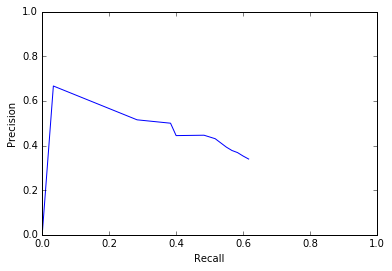

In [139]:
def display_pr_curve_from_cm(confusion_mats):
    precisions = []
    recalls = []
    
    for confusion_mat in confusion_mats:
        if (float(confusion_mat[1,1]) + float(confusion_mat[0,1])) == 0:
            precisions.append(0.0)
        else:
            precisions.append(float(confusion_mat[1,1]) / (float(confusion_mat[1,1]) + float(confusion_mat[0,1])))
        if (float(confusion_mat[1,1]) + float(confusion_mat[1,0])) == 0:
            recalls.append(0.0)
        else:
            recalls.append(float(confusion_mat[1,1]) / (float(confusion_mat[1,1]) + float(confusion_mat[1,0])))
        
#     tmp_pr_df = %precisiontaFrame({"precision": precisions, "recall": recalls})
#     tmp_pr_df.plot
#     plt.plot(precisions, recalls)
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    print(recalls)
    print(precisions)
  
display_pr_curve_from_cm(confusion_mats_final)

[0.3333333333333333, 0.34285714285714286, 0.34285714285714286, 0.34285714285714286, 0.3235294117647059, 0.34375, 0.3793103448275862, 0.4074074074074074, 0.42857142857142855, 0.5, 0.5, 0.5, 0.5]
[0.6, 0.6, 0.6, 0.6, 0.55, 0.55, 0.55, 0.55, 0.45, 0.45, 0.35, 0.3, 0.05]


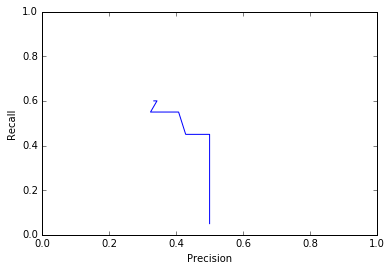

In [130]:
def display_pr_curve_from_cm(confusion_mats):
    precisions = []
    recalls = []
    
    for confusion_mat in confusion_mats:
        precisions.append(float(confusion_mat[1,1]) / (float(confusion_mat[1,1]) + float(confusion_mat[0,1])))
        recalls.append(float(confusion_mat[1,1]) / (float(confusion_mat[1,1]) + float(confusion_mat[1,0])))
        
#     tmp_pr_df = %precisiontaFrame({"precision": precisions, "recall": recalls})
#     tmp_pr_df.plot
    plt.plot(precisions, recalls)
#     plt.xlabel("Precision")
#     plt.ylabel("Recall")
    plt.xlim(0,1)
    plt.ylim(0,1)
    
    print(precisions)
    print(recalls)
  
display_pr_curve_from_cm(confusion_mats_final)

In [113]:
analyze_detections(np.zeros((2,2)), test_im_windows_reduced, test_all_im_windows[0])

array([[ 0.,  2.],
       [ 2.,  2.]])

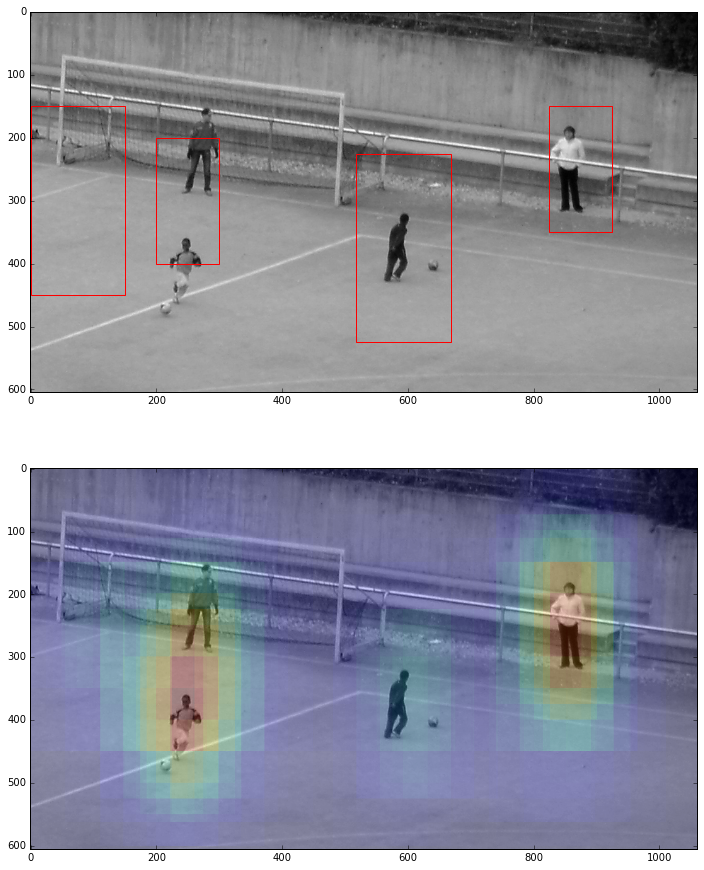

In [93]:
# test nms
visualize_windows(test_im, test_im_windows_reduced, test_im_windows_original, window_probs_original[:,1])


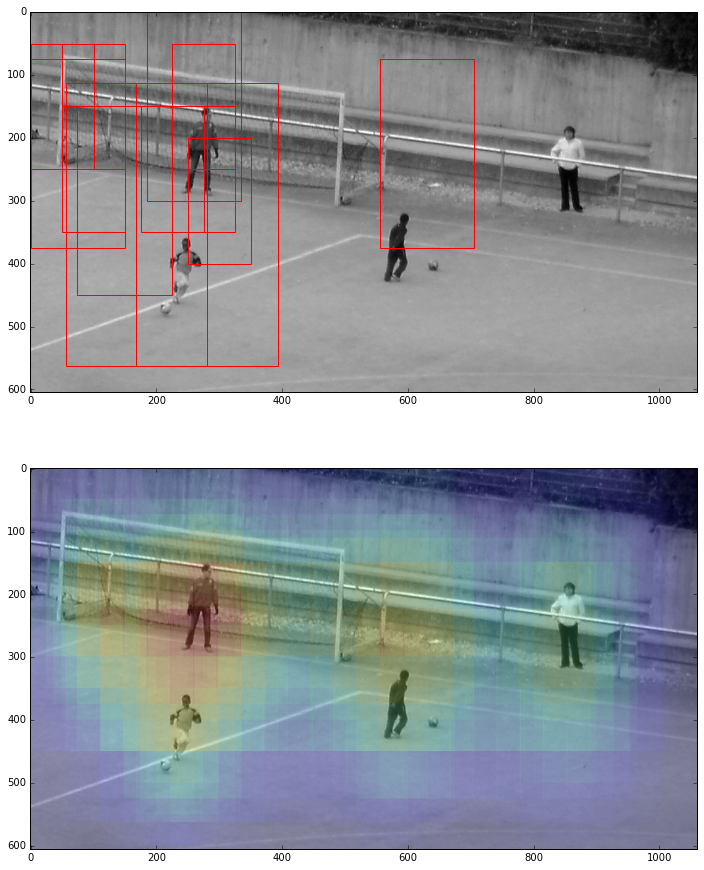

In [127]:
# test nms
visualize_windows(test_im, test_im_windows_reduced, test_im_windows_original, window_probs_original[:,1])


In [144]:
num_test_ims_to_use = 15
window_iou_threshold = 0.3

precisions = []
recalls = []
confusion_mats = []

class_prob_threshold = 0.5
#  the fill the confusion matrix for that prob theshold, get precision and recall
#  need to run each confusion matrix through pos and neg test images

clf = visual_classifier()
confusion_mat = np.zeros((2,2))



"""Test Positive Windows"""
test_im = None
for n, test_im in enumerate(test_pos_full_im_array[11:num_test_ims_to_use]):
    print(n, len(test_pos_full_im_array))

    #  get sliding windows
    test_im_windows_original = sliding_window(test_im)

    if len(test_im_windows_original) > 0:
        window_probs_original = clf.predict_prob(["sift","sift","vector","random forest"], test_im,  
                                                 x_train_masks=test_im_windows_original, train_new=False)


        #  filter out low prob positive windows
        pos_indexes = []
        for i, x in enumerate(window_probs_original):
            if x[1] > class_prob_threshold:
                pos_indexes.append(i)

        test_im_windows = test_im_windows_original[pos_indexes]
        window_probs = window_probs_original[pos_indexes]



        #  Non-Maximal Supression
        #  only accept the max prob window of windows that overlap it my 50%


        remaining_windows = np.ones(len(test_im_windows))

        #  try every combination of windows
        for i in range(len(test_im_windows)):
            for j in range(i + 1, len(test_im_windows)):

                #  if two windows share half of their area then eliminate the smaller one
                if iou(test_im_windows[i], test_im_windows[j])[0] >= window_iou_threshold:
                    if window_probs[i][1] > window_probs[j][1]:
                        remaining_windows[j] = 0.0
                    else:
                        remaining_windows[i] = 0.0


        test_im_windows_reduced = test_im_windows[remaining_windows.astype(bool)]
        window_probs_reduced = window_probs[remaining_windows.astype(bool)]

    break



(0, 288)


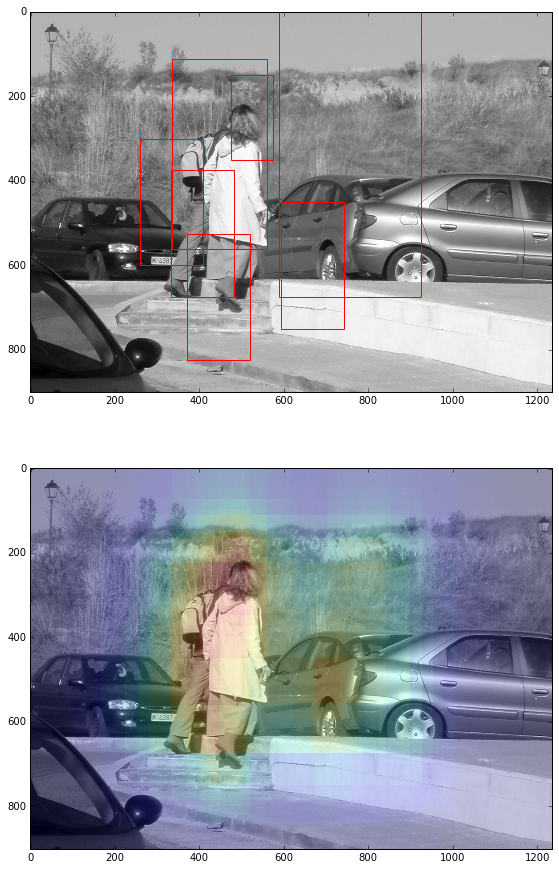

In [145]:
# test nms
visualize_windows(test_im, test_im_windows_reduced, test_im_windows_original, window_probs_original[:,1])


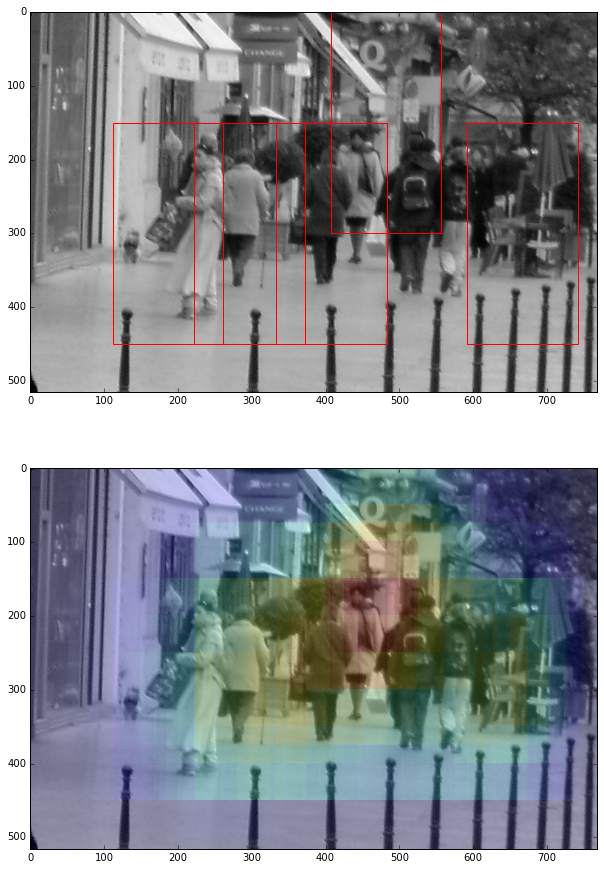

In [141]:
# test nms
visualize_windows(test_im, test_im_windows_reduced, test_im_windows_original, window_probs_original[:,1])
